In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install seaborn

Mounted at /content/drive
Working directory set to: /content/drive/My Drive/load_type_prediction
Available columns and data types:
Date_Time                                object
Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                     float64
Load_Type                                object
dtype: object
Seaborn style not found, using default Matplotlib style.


/tmp/ipython-input-5-2451599595.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


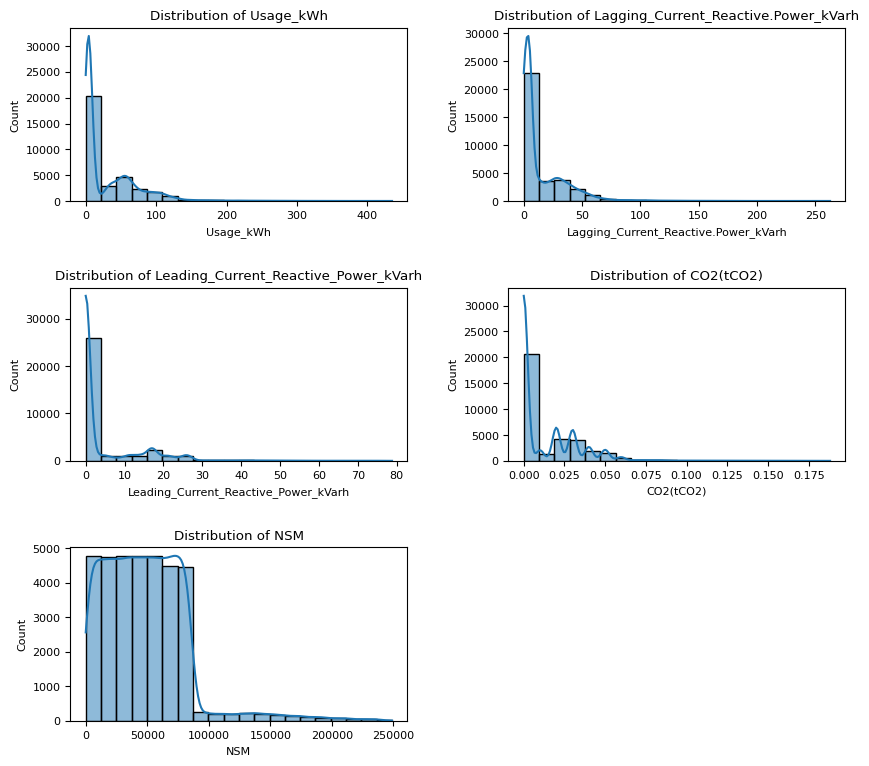

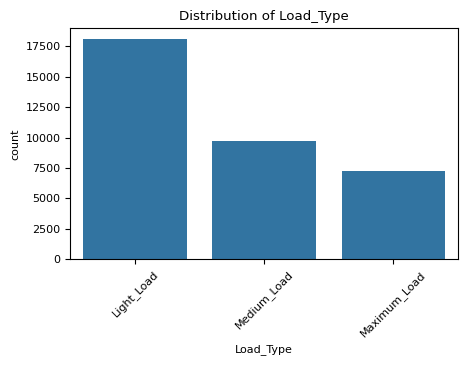

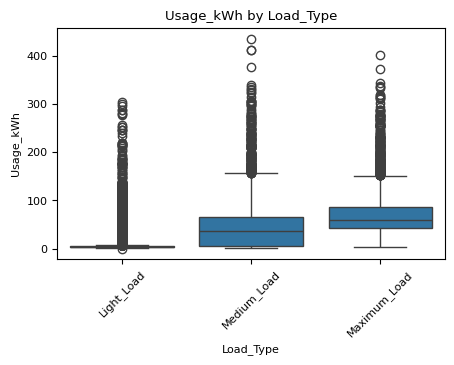

<Figure size 500x300 with 0 Axes>

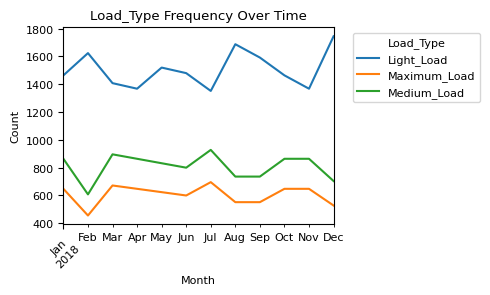

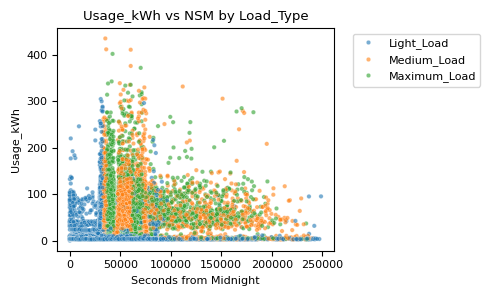


--- Enhanced Data Quality Check ---
Missing Values (NaN/None):
Date_Time                                  0
Usage_kWh                               1559
Lagging_Current_Reactive.Power_kVarh     876
Leading_Current_Reactive_Power_kVarh    1156
CO2(tCO2)                                455
Lagging_Current_Power_Factor             350
Leading_Current_Power_Factor            1471
NSM                                      455
Load_Type                                  0
Date                                       0
dtype: int64

Date_Time - Rows with empty strings (''): 0

Load_Type - Rows with empty strings (''): 0

Unique Values per Column:
Date_Time: 35040 unique values
Usage_kWh: 6615 unique values
Lagging_Current_Reactive.Power_kVarh: 4634 unique values
Leading_Current_Reactive_Power_kVarh: 1906 unique values
CO2(tCO2): 1377 unique values
Lagging_Current_Power_Factor: 8454 unique values
Leading_Current_Power_Factor: 6465 unique values
NSM: 3510 unique values
Load_Type: 3 unique values
Da

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import time

# Install seaborn if not already installed (for Colab)
try:
    import seaborn
except ImportError:
    !pip install seaborn
    import seaborn

# Mount Google Drive with retry logic
from google.colab import drive
max_retries = 3
for attempt in range(max_retries):
    try:
        drive.mount('/content/drive', force_remount=True)
        break
    except Exception as e:
        print(f"Mount attempt {attempt + 1} failed: {e}")
        if attempt < max_retries - 1:
            time.sleep(5)  # Wait 5 seconds before retrying
        else:
            raise Exception("Failed to mount Google Drive after multiple attempts.")

# Set working directory with error handling
try:
    os.chdir('/content/drive/My Drive/load_type_prediction/')
    print("Working directory set to:", os.getcwd())
except FileNotFoundError:
    raise FileNotFoundError("Directory /content/drive/My Drive/load_type_prediction/ not found. Please create it and upload the dataset.")
except Exception as e:
    raise Exception(f"Error changing directory: {e}")

# Load the dataset
df = pd.read_csv('data/raw/power_data.csv')

# Check available columns and data types
print("Available columns and data types:")
print(df.dtypes)
if 'Date_Time' not in df.columns:
    raise KeyError("Column 'Date_Time' not found in the dataset. Please check column names.")

# Convert 'Date_Time' to datetime and sort by date, using dayfirst=True for DD-MM-YYYY
df['Date'] = pd.to_datetime(df['Date_Time'], dayfirst=True)
df = df.sort_values('Date')

# Set plot style and size for small plots (4 per A4, ~5x3 inches)
try:
    plt.style.use('seaborn')
except OSError:
    print("Seaborn style not found, using default Matplotlib style.")
    plt.style.use('default')
plt.rcParams['figure.figsize'] = (5, 3)
plt.rcParams['font.size'] = 8

# 1. Univariate Analysis: Distribution of continuous features
continuous_features = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'NSM']
fig, axes = plt.subplots(3, 2, figsize=(10, 9), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
axes = axes.flatten()
for i, feature in enumerate(continuous_features):
    if feature in df.columns:
        sns.histplot(data=df, x=feature, ax=axes[i], bins=20, kde=True)
        axes[i].set_title(f'Distribution of {feature}')
    else:
        axes[i].text(0.5, 0.5, f'{feature} not found', ha='center')
for j in range(len(continuous_features), len(axes)):
    axes[j].remove()
plt.tight_layout()
plt.show()

# 2. Univariate Analysis: Load_Type distribution
plt.figure()
sns.countplot(data=df, x='Load_Type')
plt.title('Distribution of Load_Type')
plt.xticks(rotation=45)
plt.show()

# 3. Bivariate Analysis: Usage_kWh vs Load_Type
plt.figure()
sns.boxplot(data=df, x='Load_Type', y='Usage_kWh')
plt.title('Usage_kWh by Load_Type')
plt.xticks(rotation=45)
plt.show()

# 4. Time-Based Analysis: Load_Type over Time (Monthly Aggregation)
plt.figure()
df.groupby(df['Date'].dt.to_period('M'))['Load_Type'].value_counts().unstack().plot()
plt.title('Load_Type Frequency Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Load_Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Bivariate Analysis: Usage_kWh vs NSM with Load_Type
plt.figure()
sns.scatterplot(data=df, x='NSM', y='Usage_kWh', hue='Load_Type', alpha=0.6, s=10)
plt.title('Usage_kWh vs NSM by Load_Type')
plt.xlabel('Seconds from Midnight')
plt.ylabel('Usage_kWh')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 7. Enhanced Data Quality Check: Missing Values and Invalid Entries
print("\n--- Enhanced Data Quality Check ---")
print("Missing Values (NaN/None):")
print(df.isnull().sum())

# Check for empty strings or whitespace-only values
for column in df.columns:
    if df[column].dtype in ['object', 'string']:  # Check string-like columns
        empty_strings = df[column].str.strip().eq("")  # Strip whitespace and check for empty
        print(f"\n{column} - Rows with empty strings (''): {empty_strings.sum()}")
        if empty_strings.sum() > 0:
            print(f"Sample rows with empty strings in {column}:")
            print(df[empty_strings].head())

# Check for unique values per column
print("\nUnique Values per Column:")
for column in df.columns:
    print(f"{column}: {df[column].nunique()} unique values")

# Summary Statistics
print("\nSummary Statistics:")
print(df[continuous_features].describe())
print("\nLoad_Type Distribution:")
print(df['Load_Type'].value_counts())